<h1 style="background-color:#a83299;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 20px 20px;font-family:cursive">Clustering text documents using k-means</h1>

In this notebook, it explained that the case of text document clustering , showing how the `scikit-learn` package can be used to perform clustering. Doing this, you will review:
1. How a document is converted into a vector of features. In particular, it considered that tf-idf vectorization.
2. How k-means clustering can be applied to perform unsupervised clustering of the documents.
3. How this is done in practice using the `scikit-learn` package.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize #Used to extract words from documents
from nltk.stem import WordNetLemmatizer #Used to lemmatize words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans

import sys
from time import time

import pandas as pd
import numpy as np

In [2]:
# Selected 3 categories from the 20 newsgroups dataset

categories = [
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['talk.religion.misc', 'comp.graphics', 'sci.space']


In [3]:
df = fetch_20newsgroups(subset='all', categories=categories, 
                             shuffle=False, remove=('headers', 'footers', 'quotes'))

In [4]:
labels = df.target
true_k = len(np.unique(labels)) ## This should be 3 in this example
print(true_k)

3


### Perform Lemmatization

In [5]:
lemmatizer = WordNetLemmatizer()
for i in range(len(df.data)):
    word_list = word_tokenize(df.data[i])
    lemmatized_doc = ""
    for word in word_list:
        lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
    df.data[i] = lemmatized_doc  

In [6]:
print(df.data[1])

 In regard to fractal commpression , I have seen 2 fractal compressed `` movie '' . They were both fairly impressive . The first one wa a 64 gray scale `` movie '' of Casablanca , it wa 1.3MB and had 11 minute of 13 fps video . It wa a little grainy but not bad at all . The second one I saw wa only 3 minute but it had 8 bit color with 10fps and measured in at 1.2MB . I consider the fractal movie a practical thing to explore . But unlike many other format out there , you do end up losing resolution . I do n't know what kind of software/hardware wa used for creating the `` movie '' I saw but the guy that showed them to me said it took 5-15 minute per frame to generate . But a I said above playback wa 10 or more frame per second . And how else could you put 11 minute on one floppy disk ?


We next convert our corpus into tf-idf vectors. We remove common stop words, terms with very low document frequency (many of them are numbers or misspells), accents. 

In [7]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=2) ## Corpus is in English
X = vectorizer.fit_transform(df.data)

In [8]:
print(X.shape)

(2588, 14447)


### Clustering using standard k-means

We first cluster documents using the standard k-means algorithm (actually, a refined variant called k-means++), without any further date preprocessing. The key parameter of choice when performing k-means is $k$. Alas, there really is no principled way to choose an initial value for $k$. Essentially we have two options:

1. We choose a value that reflects our knowledge about the data, as in this case
2. We may try several value, possibly in increasing order. We proceed this way as long as the quality of the resulting clustering (as measured by one or more quality indices) increases and stop when it starts decreasing. 

In this specific case, we set $k = 3$ of course

In [9]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

done in 0.871s


### Standard measures of cluster quality

In [10]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.357
Completeness: 0.406
V-measure: 0.380
Adjusted Rand-Index: 0.321
Silhouette Coefficient: 0.010


### Identify the 10 most relevant terms in each cluster

In [11]:
centroids = km.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: wa space like just ha think time year orbit launch
Cluster 1: god wa jesus people christian did think say right bible
Cluster 2: file image thanks format program know graphic looking ftp gif


### Visualization

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [13]:
def frequencies_dict(cluster_index):
    if cluster_index > true_k - 1:
        return
    term_frequencies = km.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

In [14]:
def makeImage(frequencies):

    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

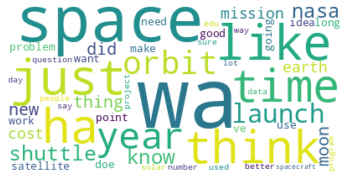

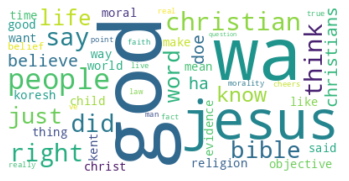

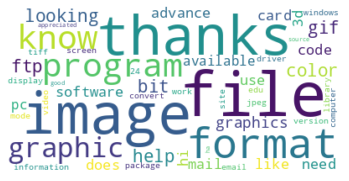

In [15]:
for i in range(true_k):
    freq = frequencies_dict(i)
    makeImage(freq)
    print()